# Analysis

This notebook includes the code for all supervised machine learning tasks performed in the paper. We start by importing the necessary Python libraries.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier,
    ExtraTreeRegressor,
    ExtraTreeClassifier,
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    Normalizer,
    PowerTransformer,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, SVC
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
)
from scipy.stats import randint, uniform, expon, loguniform
from IPython.display import display

# Set global random state params
RNG_SEED = 0
np.random.seed(seed=RNG_SEED)

%matplotlib inline

## Load the Data

The data is loaded from a cleaned CSV file called `parsed_data.csv`. The uncleaned data can be found in the `data` folder, where each system's data is an extensionless text file.

In [2]:
df = pd.read_csv('data/parsed_data.csv')
df

,t,Steps,Event,idx,TFSI,TFSI-flip,EC,EC-flip,Li,Li-flip,...,EC-2-flip,Li-2,Li-2-flip,dx,dy,dz,dr,d,fast,system
0,459.0,306,1,1.0,0.0,78,4.0,50,0.0,0,...,147,0.0,0,-0.02,-1.10,-0.73,1.32,243.13,0.0,B2T1
1,459.0,306,1,2.0,2.0,122,3.0,80,0.0,106,...,164,1.0,110,1.05,-0.61,-0.49,1.31,250.02,0.0,B2T1
2,459.0,306,1,3.0,2.0,99,2.0,104,0.0,8,...,195,1.0,76,-0.27,0.40,0.92,1.04,251.00,0.0,B2T1
3,459.0,306,1,4.0,1.0,125,3.0,6,0.0,0,...,125,0.0,0,0.47,0.05,0.59,0.76,203.19,0.0,B2T1
4,459.0,306,1,5.0,0.0,0,4.0,38,0.0,0,...,162,0.0,16,1.51,1.04,-0.15,1.84,247.00,0.0,B2T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24895,8721.0,5814,19,96.0,2.0,41,2.0,18,0.0,3,...,60,0.0,50,0.98,-3.90,-1.55,4.31,344.49,1.0,B8T5
24896,8721.0,5814,19,97.0,3.0,164,1.0,9,0.0,0,...,127,1.0,39,-6.13,3.94,-1.87,7.52,347.39,1.0,B8T5
24897,8721.0,5814,19,98.0,2.0,16,2.0,6,0.0,0,...,31,0.0,0,-0.31,0.77,0.09,0.83,335.26,0.0,B8T5
24898,8721.0,5814,19,99.0,0.0,29,4.0,31,0.0,0,...,64,0.0,0,-1.63,1.24,-0.01,2.05,336.03,0.0,B8T5


Only a few of these columns are useful to the task, and they are selected below.

In [3]:
columns = [
    "TFSI",
    "TFSI-flip",
    "EC",
    "EC-flip",
    "Li",
    "Li-flip",
    "TFSI-2",
    "TFSI-2-flip",
    "EC-2",
    "EC-2-flip",
    "Li-2",
    "Li-2-flip",
    "dr",
]

data = df[columns]
data

,TFSI,TFSI-flip,EC,EC-flip,Li,Li-flip,TFSI-2,TFSI-2-flip,EC-2,EC-2-flip,Li-2,Li-2-flip,dr
0,0.0,78,4.0,50,0.0,0,2.0,135,0.0,147,0.0,0,1.32
1,2.0,122,3.0,80,0.0,106,2.0,194,3.0,164,1.0,110,1.31
2,2.0,99,2.0,104,0.0,8,4.0,161,3.0,195,1.0,76,1.04
3,1.0,125,3.0,6,0.0,0,2.0,95,1.0,125,0.0,0,0.76
4,0.0,0,4.0,38,0.0,0,0.0,109,1.0,162,0.0,16,1.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24895,2.0,41,2.0,18,0.0,3,2.0,134,0.0,60,0.0,50,4.31
24896,3.0,164,1.0,9,0.0,0,1.0,184,0.0,127,1.0,39,7.52
24897,2.0,16,2.0,6,0.0,0,2.0,93,0.0,31,0.0,0,0.83
24898,0.0,29,4.0,31,0.0,0,0.0,112,0.0,64,0.0,0,2.05


Machine learning will first be done on the structural features (coordination numbers), then on the structural and dynamic features (changes in coordination numbers). For this reason, it's useful to have a list of columns pertaining to just the coordination numbers and changes/flips in coordination number:

In [4]:
structure = [i for i in data.columns[0:-1] if not i.endswith('flip')]
flips = [i for i in data.columns[0:-1] if i.endswith('flip')]

print(structure)
print(flips)

['TFSI', 'EC', 'Li', 'TFSI-2', 'EC-2', 'Li-2']
['TFSI-flip', 'EC-flip', 'Li-flip', 'TFSI-2-flip', 'EC-2-flip', 'Li-2-flip']


## Helper Functions

A lot of this code is going to be reused a bunch throughout the notebook. Each and every model will go through a randomized hyperparamter search cross-validation using `RandomizedSearchCV` (aside from the dummy models, which don't really count). Instead of creating 

In [5]:
def randomized_search(model, param_dist, X_train, y_train, iters=50, regression=True):
    """
    Performs a RandomizedSearchCV to optimize hyperparameters.
    For the best model, displays the mean and standard deviation of several scoring 
    metrics on the training and holdout (validation) splits for 5-fold cross-validation.

    Args:
        model (sklearn estimator): estimator or pipeline to cross-validate
        param_dist (dict): ranges or distributions of hyperparameters to sample from
        X_train (array-like): training samples for regression
        y_train (array-like): target/label for regression
        iters (int, optional): Number of parameter settings sampled. Defaults to 50.
        regression (bool, optional): Regression (True) or classification (False). Defaults to True.

    Returns:
        RandomizedSearchCV: randomized hyperparameter search CV fitted on training data
    """

    # Get multiple scorers from sklearn.metrics to evaluate during cross-validation
    if regression:
        scoring = {
            "R2": "r2",
            "MAE": "neg_mean_absolute_error",
            "MSE": "neg_mean_squared_error",
            "RMSE": "neg_root_mean_squared_error",
        }
    else:  # classification metrics
        scoring = {
            "Accuracy": "accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1 Score": "f1",
            "ROC AUC": "roc_auc",
        }
    # Randomized hyperparamter search cross-validation on estimator and parameter distributions
    random_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=iters,
        scoring=scoring,  # record scores based on all our scoring metrics
        refit="MSE" if regression else "F1 Score",
        cv=5,  # 5-fold cross-validation for each parameter setting sample
        return_train_score=True,  # return scores on training data as well as validation data
        random_state=RNG_SEED,
        n_jobs=-1,  # use all CPU cores
        verbose=10,
    )
    random_cv.fit(X_train, y_train)  # optimize hyperparameters on training data
    results = random_cv.cv_results_  # results of cross-validation
    idx = random_cv.best_index_  # index corresponding to best-performing model

    # For the best model, get the mean and standard deviation of scores on train and val data
    train_means = [abs(results[f"mean_train_{score}"][idx]) for score in scoring.keys()]
    train_std = [results[f"std_train_{score}"][idx] for score in scoring.keys()]
    # By convention, scikit-learn uses "test" to denote holdout/validation splits
    val_means = [abs(results[f"mean_test_{score}"][idx]) for score in scoring.keys()]
    val_std = [results[f"std_test_{score}"][idx] for score in scoring.keys()]

    # Create a DataFrame of the cross-validation scoring summary for the best model
    cross_val_summary = pd.DataFrame(
        data={
            "Mean (Train)": train_means,
            "STD (Train)": train_std,
            "Mean (Val)": val_means,
            "STD (Val)": val_std,
        },
        index=scoring.keys(),
    )
    print("Best hyperparameters:", random_cv.best_params_)
    print("\nMean and standard deviation of performance on 5-fold cross-validation:")
    display(cross_val_summary)  # use IPython display for prettier printing of DataFrame
    return random_cv

In [6]:
def score_summary(model, X_train, X_test, y_train, y_test, regression=True):
    """
    Prints scoring metrics of a fitted estimator on training and test data.
    For regression tasks, scores on R2, MAE, MSE, and RMSE.
    For classification tasks, scores on accuracy, precision, recall, F1, and ROC AUC.

    Args:
        model (sklearn estimator): fitted estimator or pipeline
        X_train (array-like): training samples
        X_test (array-like): test/holdout samples
        y_train (array-like): target values for the training set
        y_test (array-like): target values for the test set
        regression (bool, optional): Regression (True) or classification (False). Defaults to True.
    Returns:
        DataFrame: model scores on training and test samples
    """
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    if regression:  # compute scoring metrics for regression
        # train scores
        train_r2 = r2_score(y_train, y_pred_train)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        train_mse = mean_squared_error(y_train, y_pred_train)
        train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
        # test scores
        test_r2 = r2_score(y_test, y_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = mean_squared_error(y_test, y_pred, squared=False)
        summary = pd.DataFrame(
            data={
                "Training Scores": [train_r2, train_mae, train_mse, train_rmse],
                "Test Scores": [test_r2, test_mae, test_mse, test_rmse],
            },
            index=["R2", "MAE", "MSE", "RMSE"],
        )
    else:  # compute scoring metrics for classification
        # train scores
        train_acc = accuracy_score(y_train, y_pred_train)
        train_rec = recall_score(y_train, y_pred_train)
        train_prec = precision_score(y_train, y_pred_train)
        train_f1 = f1_score(y_train, y_pred_train)
        train_roc = roc_auc_score(y_train, y_pred_train)
        # test scores
        test_acc = accuracy_score(y_test, y_pred)
        test_rec = recall_score(y_test, y_pred)
        test_prec = precision_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_roc = roc_auc_score(y_test, y_pred)
        summary = pd.DataFrame(
            data={
                "Training Scores": [train_acc, train_rec, train_prec, train_f1, train_roc],
                "Test Scores": [test_acc, test_rec, test_prec, test_f1, test_roc],
            },
            index=["Accuracy", "Recall", "Precision", "F1 Score", "ROC AUC"],
        )
    print("\nScore summary on full training data and test data:")
    display(summary)
    return summary


def plot_pred_act(act, pred, label=r"$\delta r\ (\AA)$", title=False, save=True, save_name="act_pred"):
    """
    Creates a parity plot for an estimator on testing data

    Args:
        act (array-like): actual values for targets, y_test
        pred (array-like): predicted values for targets
        label (str, optional): name of target y for axes. Defaults to r"$\delta r\ (\AA)$".
        title (str/bool, optional): name of estimator for plot title. Defaults to False.
        save (bool, optional): Whether to save plot image. Defaults to True.
        save_name (str, optional): Filename for saved plot image. Defaults to "act_pred".
    """

    sns.set(style="ticks", font_scale=1.5)
    xy_max = np.max([np.max(act), np.max(pred)])
    xy_min = np.min([np.min(act), np.min(pred)])
    r2 = r2_score(act, pred)
    # make a joint regplot (scatter + linear fit) with histogram/kde of label distributions
    plot = sns.jointplot(
        x=act,
        y=pred,
        kind="reg",
        height=7,
        ratio=4,
        color="#611f53",
        marginal_ticks=True,
        xlim=(xy_min - 0.5, xy_max + 0.5),  # limits with padding
        ylim=(xy_min - 0.5, xy_max + 0.5),
        # scatter plot point kwds
        scatter_kws=dict(s=100, alpha=0.4, edgecolor="k", color="#f6ab83"),
        # fit line kwds
        line_kws=dict(label="linear fit", lw=4),
        # histogram/kde kwds
        marginal_kws=dict(bins=10, kde=True),
    )
    # plot ideal linear fit
    plot.ax_joint.plot([xy_min, xy_max], [xy_min, xy_max], "k--", label="ideal")
    # set title, axes labels, make legend, and show plot
    plot.set_axis_labels(f"Actual {label}", f"Predicted {label}")
    plot.ax_joint.set_xticks(np.linspace(0, 14, 8))  # keep x-axis ticks consistent
    if title:  # truth value of a str is True, False otherwise
        plot.fig.suptitle(fr"{title}: $R^2$ = {r2:.4f}")
    plot.fig.tight_layout()
    plot.ax_joint.legend()
    if save:
        plt.savefig(f"figures/{save_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


def plot_confusion_matrix(model, X_test, y_test, save=True, name="classification"):
    """
    Creates a confusion matrix on the test data

    Args:
        model (sklearn estimator): estimator or pipeline for classification
        X_test (array-like): test samples
        y_test (array-like): ground truths for test set
        save (bool, optional): Whether to save an image of the plot. Defaults to True.
        name (str, optional): Filename for the saved image. Defaults to "classification".
    """
    f1 = f1_score(y_test, model.predict(X_test))
    sns.set(font_scale=2)
    plt.figure(figsize=(10,8))
    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(
        conf_matrix,
        annot=True,
        xticklabels=["slow", "fast"],
        yticklabels=["slow", "fast"],
        cbar=True,
        cmap="flare",
        fmt="g",
        linewidths=3,
    )
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.yticks(rotation=0)
    plt.title(f"Classification F1: {f1:.4f}")
    if save:
        plt.savefig(f"figures/{name}.png", dpi=500, bbox_inches="tight")
    plt.show()

## Coordination Numbers as the Only Features

In [7]:
X = data[structure]
y = data['dr']

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
struct_results = {}

### Dummy


Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.000000,-0.000969
MAE,1.415430,1.381654
MSE,3.294930,3.131351
RMSE,1.815194,1.769562


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


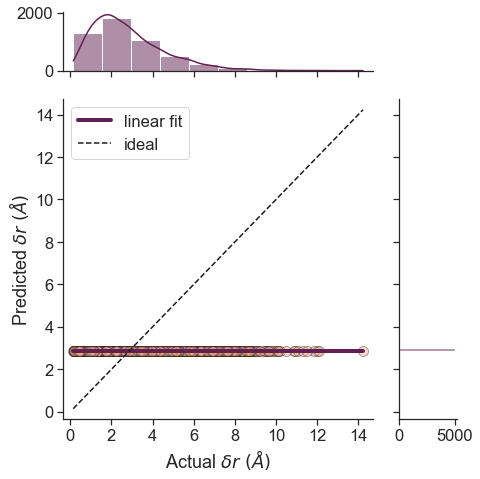

In [8]:
dummy = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DummyRegressor())
])
dummy.fit(X_train, y_train)

struct_results["dummy"] = score_summary(dummy, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, dummy.predict(X_test), save_name="struct_actpred_dummy")

### Linear (Polynomial Ridge)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 1.6598654663071277}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.014724,0.001163,0.011330,0.004842
MAE,1.401687,0.004476,1.404144,0.016822
MSE,3.246330,0.019848,3.256197,0.079020
RMSE,1.801749,0.005504,1.804360,0.021956



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.014453,0.006969
MAE,1.401934,1.375519
MSE,3.247309,3.106518
RMSE,1.802029,1.762532


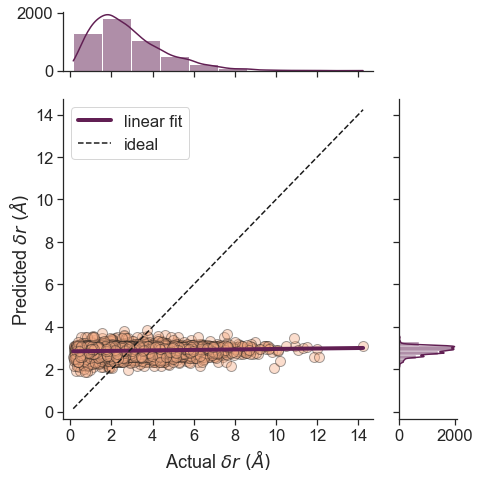

In [9]:
# create polynomial features, scale/normalize features, then instantiate model
linear = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

# set up distributions of hyperparameters for optimization
linear_params = {"model__alpha": loguniform(1E-5, 10)}

# perform a randomized hyperparameter search and print out CV scoring metrics
linear_random_cv = randomized_search(linear, linear_params, X_train, y_train)
best_linear = linear_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["ridge"] = score_summary(best_linear, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_linear.predict(X_test), save_name="struct_ridge")

### Nearest Neighbors Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 18, 'model__n_neighbors': 14, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.013781,0.002536,0.061307,0.017908
MAE,1.416256,0.011686,1.447825,0.016304
MSE,3.340284,0.026234,3.494344,0.053712
RMSE,1.827630,0.007182,1.869261,0.014353



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,-0.019129,-0.079234
MAE,1.418923,1.431201
MSE,3.357958,3.376188
RMSE,1.832473,1.837441


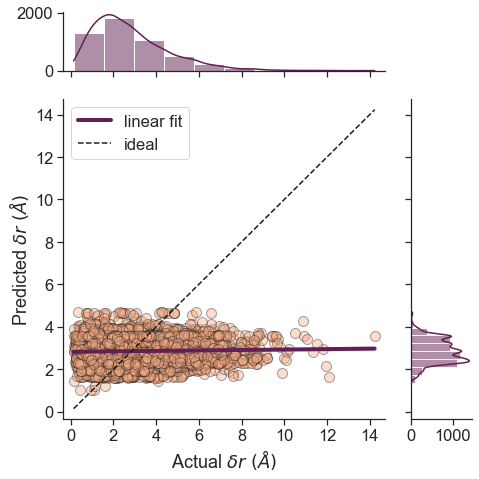

In [10]:
# set up a pipeline to scale/normalize features, then instantiate model
knr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor())
])

# create distributions of hyperparameters to explore
knr_params = {
    "model__n_neighbors": randint(5, 15),
    "model__weights": ["uniform", "distance"],
    "model__leaf_size": randint(10, 60),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
knr_random_cv = randomized_search(knr, knr_params, X_train, y_train)
best_knr = knr_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["knn"] = score_summary(best_knr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_knr.predict(X_test), save_name="struct_knn")

### Tree-Based Models

#### Decision Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 42, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 9, 'model__min_samples_split': 4, 'model__splitter': 'random'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.015935,0.002578,0.003708,0.003913
MAE,1.401164,0.004763,1.410481,0.014846
MSE,3.242321,0.017914,3.281098,0.070398
RMSE,1.800638,0.004974,1.811276,0.019468



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.021084,0.003633
MAE,1.396801,1.376459
MSE,3.225458,3.116953
RMSE,1.795956,1.765489


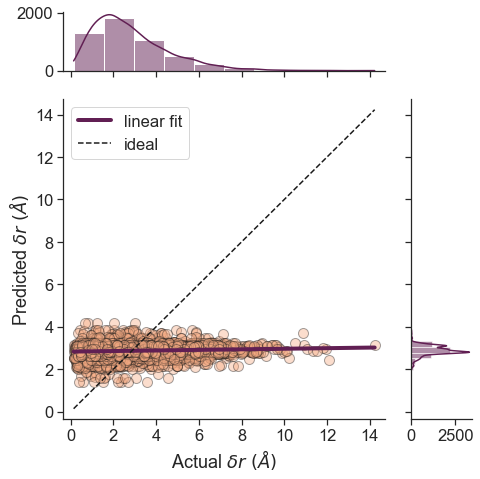

In [11]:
# set up a pipeline to scale/normalize features, then instantiate model
dtr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeRegressor(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
dtr_params = {
    "model__splitter": ['best', 'random'],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
dtr_random_cv = randomized_search(dtr, dtr_params, X_train, y_train)
best_dtr = dtr_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["dtr"] = score_summary(best_dtr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_dtr.predict(X_test), save_name="struct_dtr")

#### Extra Trees Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 92, 'model__max_features': 'log2', 'model__min_samples_leaf': 9, 'model__min_samples_split': 14}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.015935,0.002578,0.003708,0.003913
MAE,1.401164,0.004763,1.410481,0.014846
MSE,3.242321,0.017914,3.281098,0.070398
RMSE,1.800638,0.004974,1.811276,0.019468



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.021084,0.003633
MAE,1.396801,1.376459
MSE,3.225458,3.116953
RMSE,1.795956,1.765489


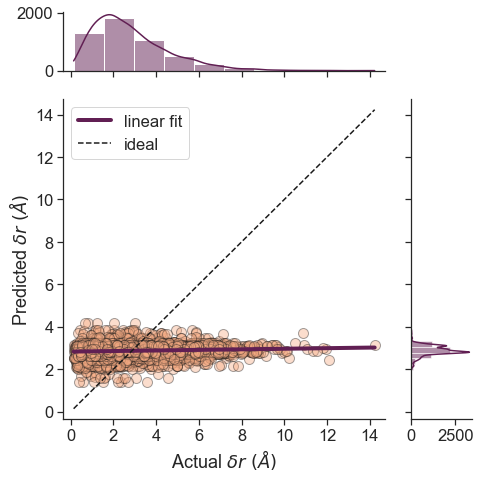

In [12]:
# set up a pipeline to scale/normalize features, then instantiate model
etr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ExtraTreeRegressor(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
etr_params = {
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
etr_random_cv = randomized_search(etr, etr_params, X_train, y_train)
best_etr = etr_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_results["etr"] = score_summary(best_etr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_etr.predict(X_test), save_name="struct_etr")

### Support Vector Machines

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 2, 'model__epsilon': 0.4166900152330658}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.015024,0.001992,0.033773,0.009456
MAE,1.352351,0.004131,1.371028,0.015544
MSE,3.344353,0.022086,3.405069,0.097898
RMSE,1.828747,0.006035,1.845089,0.026729



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,-0.016186,-0.024943
MAE,1.354020,1.331359
MSE,3.348262,3.206348
RMSE,1.829826,1.790628


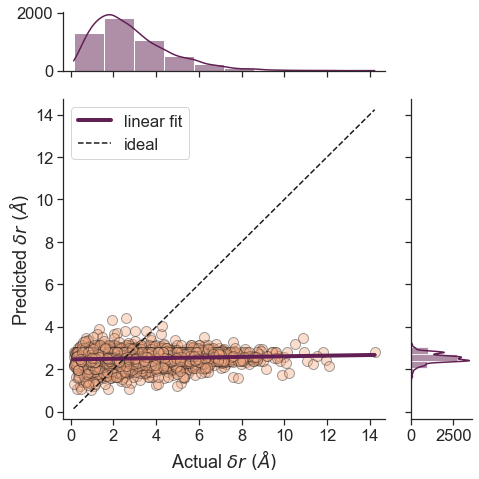

In [14]:
svr = Pipeline([("scaler", StandardScaler()), ("model", SVR(kernel="rbf"))])

svr_params = {"model__C": randint(1, 50), "model__epsilon": uniform(0.1, 0.4)}

svr_random_cv = randomized_search(svr, svr_params, X_train, y_train, iters=20)
best_svr = svr_random_cv.best_estimator_

struct_results["svr"] = score_summary(best_svr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_svr.predict(X_test), save_name="struct_svr")

### Ensemble Methods

#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': False, 'model__max_depth': 8, 'model__max_features': 'log2', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 224}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.026383,0.001498,0.009982,0.004164
MAE,1.393962,0.004468,1.405747,0.015996
MSE,3.207910,0.018622,3.260520,0.073784
RMSE,1.791056,0.005195,1.805575,0.020476



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.025128,0.006938
MAE,1.394942,1.374103
MSE,3.212135,3.106614
RMSE,1.792243,1.762559


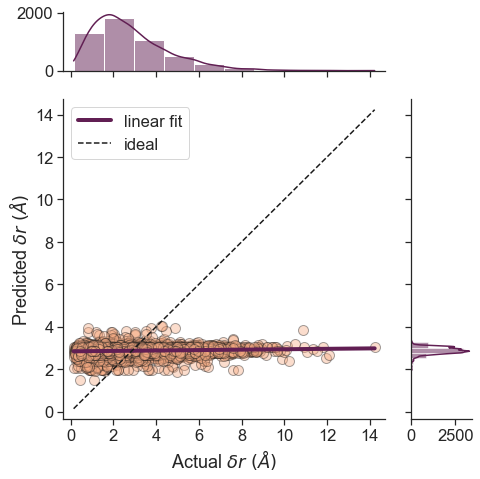

In [15]:
rfr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=RNG_SEED))
])

rfr_params = {
    "model__n_estimators": randint(10, 500),
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__bootstrap": [True, False],
}

rf_random_cv = randomized_search(rfr, rfr_params, X_train, y_train)
best_rfr = rf_random_cv.best_estimator_

struct_results["rfr"] = score_summary(best_rfr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_rfr.predict(X_test), save_name="struct_rfr")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.44513474834717914, 'model__max_depth': 4, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 301, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.055452,0.002020,0.010669,0.010067
MAE,1.366303,0.004757,1.415868,0.016951
MSE,3.112122,0.016678,3.328276,0.069718
RMSE,1.764114,0.004723,1.824255,0.019182



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.049577,-0.017369
MAE,1.371584,1.386724
MSE,3.131578,3.182653
RMSE,1.769627,1.783999


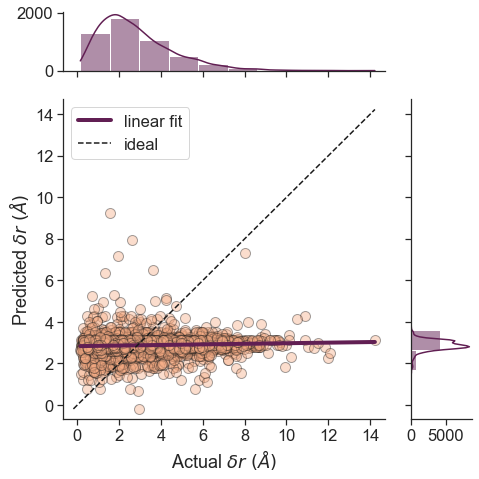

In [16]:
gbr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(random_state=RNG_SEED))
])

gbr_params = {
    "model__n_estimators": randint(10, 500),
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(1, 100),
    "model__learning_rate": uniform(0.1, 0.8),
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__warm_start": [True, False],
}

gbr_random_cv = randomized_search(gbr, gbr_params, X_train, y_train)
best_gbr = gbr_random_cv.best_estimator_

struct_results["gbr"] = score_summary(best_gbr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_gbr.predict(X_test), save_name="struct_gbr")

### Classification

In [17]:
X = data[structure]
y = df['fast']

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
struct_class_results = {}


Score summary on full training data and test data:


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Training Scores,Test Scores
Accuracy,0.615562,0.63012
Recall,0.000000,0.00000
Precision,0.000000,0.00000
F1 Score,0.000000,0.00000
ROC AUC,0.500000,0.50000


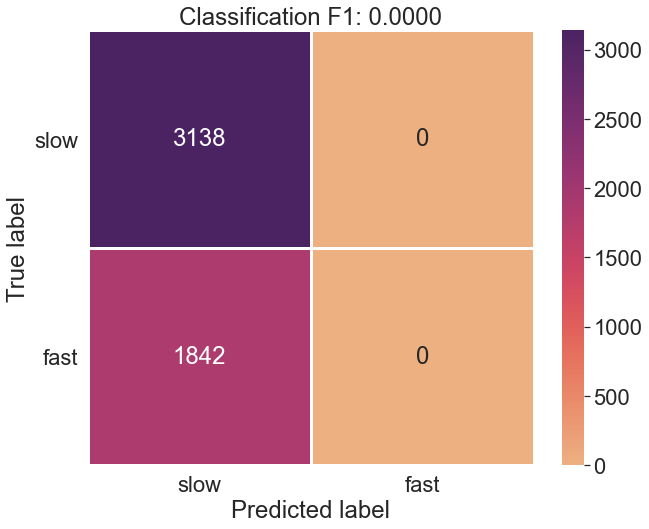

In [18]:
dummy_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DummyClassifier())
])
dummy_clf.fit(X_train, y_train)
struct_class_results["dummy"] = score_summary(dummy_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(dummy_clf, X_test, y_test, name="struct_class_dummy")

#### Ridge

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 2.2420123713724416}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.616391,0.000415,0.615161,0.000699
Precision,0.582032,0.035448,0.478120,0.068503
Recall,0.007672,0.002892,0.006399,0.002241
F1 Score,0.015115,0.005654,0.012599,0.004349
ROC AUC,0.559793,0.003143,0.553311,0.012234



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.616516,0.629518
Recall,0.005746,0.002714
Precision,0.637681,0.384615
F1 Score,0.011389,0.005391
ROC AUC,0.501853,0.500083


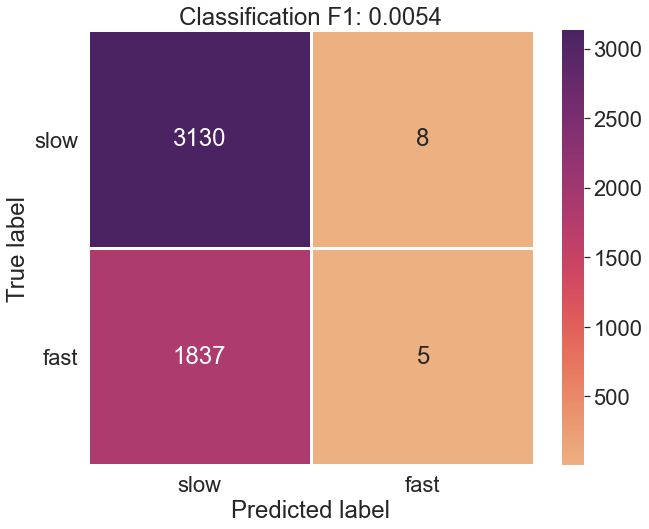

In [19]:
# create polynomial features, scale/normalize features, then instantiate model
ridge_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
    ("model", RidgeClassifier(random_state=RNG_SEED))
])

# set up distributions of hyperparameters for optimization
ridge_clf_params = {"model__alpha": loguniform(1E-5, 10)}

# perform a randomized hyperparameter search and print out CV scoring metrics
ridge_clf_random_cv = randomized_search(ridge_clf, ridge_clf_params, X_train, y_train, regression=False)
best_ridge_clf = ridge_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_class_results["ridge"] = score_summary(best_ridge_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_ridge_clf, X_test, y_test, name="struct_class_ridge")

#### Decision Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'gini', 'model__max_depth': 57, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__splitter': 'random'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.633672,0.000585,0.603514,0.003089
Precision,0.644984,0.013858,0.408630,0.020811
Recall,0.105575,0.009232,0.069471,0.005016
F1 Score,0.181197,0.013083,0.118666,0.007596
ROC AUC,0.620299,0.002081,0.536508,0.009903



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.631627,0.619277
Recall,0.093236,0.052660
Precision,0.644404,0.391129
F1 Score,0.162902,0.092823
ROC AUC,0.530552,0.502270


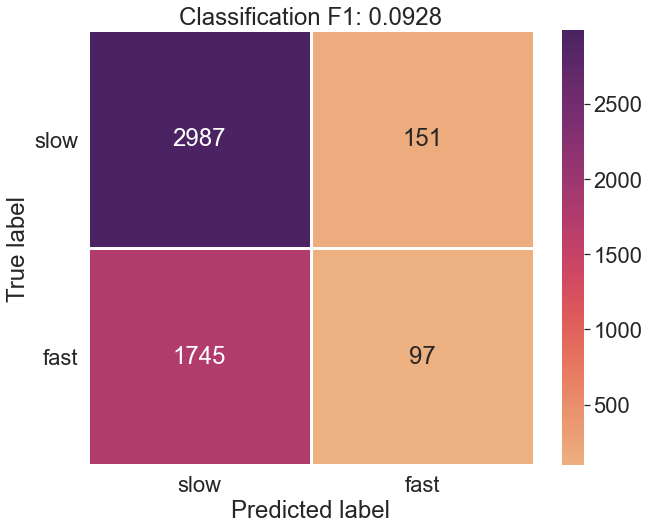

In [20]:
# set up a pipeline to scale/normalize features, then instantiate model
dt_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
dt_clf_params = {
    "model__criterion": ["gini", "entropy"],
    "model__splitter": ['best', 'random'],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
dt_clf_random_cv = randomized_search(dt_clf, dt_clf_params, X_train, y_train, regression=False)
best_dt_clf = dt_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_class_results["dt"] = score_summary(best_dt_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_dt_clf, X_test, y_test, name="struct_class_dt")

#### Extra Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'gini', 'model__max_depth': 57, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__splitter': 'random'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.633672,0.000585,0.603514,0.003089
Precision,0.644984,0.013858,0.408630,0.020811
Recall,0.105575,0.009232,0.069471,0.005016
F1 Score,0.181197,0.013083,0.118666,0.007596
ROC AUC,0.620299,0.002081,0.536508,0.009903



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.631627,0.619277
Recall,0.093236,0.052660
Precision,0.644404,0.391129
F1 Score,0.162902,0.092823
ROC AUC,0.530552,0.502270


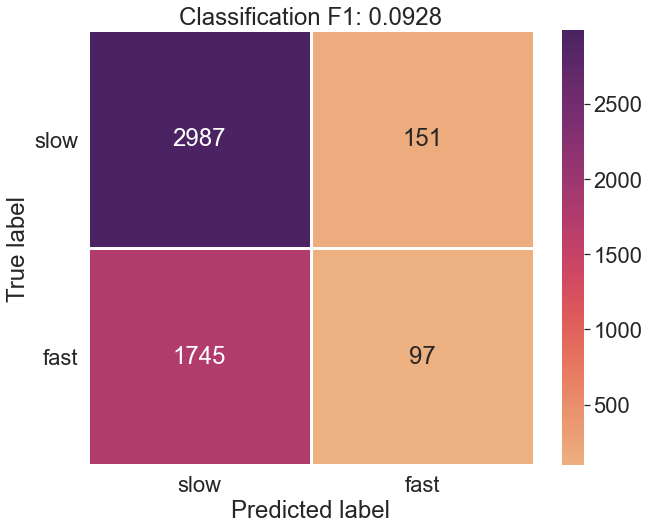

In [21]:
# set up a pipeline to scale/normalize features, then instantiate model
et_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ExtraTreeClassifier(random_state=RNG_SEED))
])

# create distributions of hyperparameters to explore
et_clf_params = {
    "model__criterion": ["gini", "entropy"],
    "model__splitter": ['best', 'random'],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

# perform a randomized hyperparameter search and print out CV scoring metrics
et_clf_random_cv = randomized_search(et_clf, et_clf_params, X_train, y_train, regression=False)
best_et_clf = et_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
struct_class_results["et"] = score_summary(best_et_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_et_clf, X_test, y_test, name="struct_class_et")

#### Nearest Neighbors 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 38, 'model__n_neighbors': 3, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.583070,0.011389,0.554016,0.009629
Precision,0.445754,0.012168,0.392747,0.005487
Recall,0.332853,0.056157,0.294598,0.050631
F1 Score,0.377394,0.037229,0.334165,0.037462
ROC AUC,0.549890,0.004002,0.508303,0.004845



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.574147,0.550201
Recall,0.336250,0.282845
Precision,0.430962,0.361806
F1 Score,0.377760,0.317489
ROC AUC,0.529485,0.494992


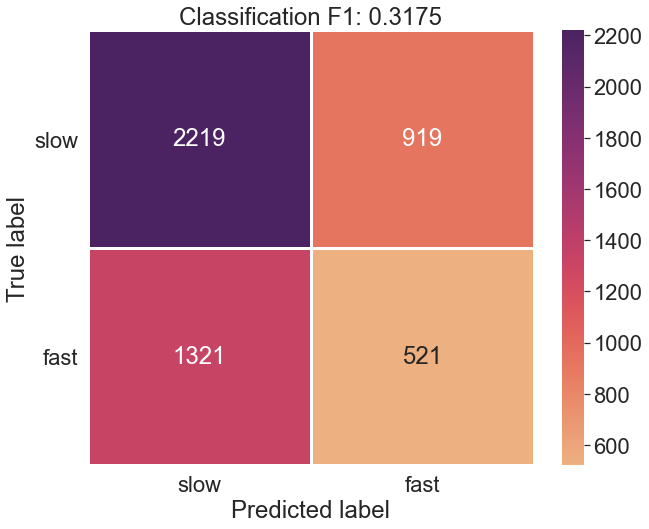

In [22]:
knn_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier())
])

knn_clf_params = {
    "model__n_neighbors": randint(1, 15),
    "model__weights": ["uniform", "distance"],
    "model__leaf_size": randint(10, 60),
}

knn_clf_random_cv = randomized_search(knn_clf, knn_clf_params, X_train, y_train, regression=False)
best_knn_clf =  knn_clf_random_cv.best_estimator_
struct_class_results["knn"] = score_summary(best_knn_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_knn_clf, X_test, y_test, name="struct_class_knn")

#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': True, 'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 392}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.525264,0.008181,0.514458,0.007264
Precision,0.419277,0.003603,0.408663,0.008091
Recall,0.608481,0.024106,0.589969,0.033796
F1 Score,0.496184,0.005736,0.482634,0.016202
ROC AUC,0.565222,0.002390,0.545268,0.015185



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.516817,0.499598
Recall,0.635022,0.623779
Precision,0.415890,0.389756
F1 Score,0.502610,0.479749
ROC AUC,0.539008,0.525242


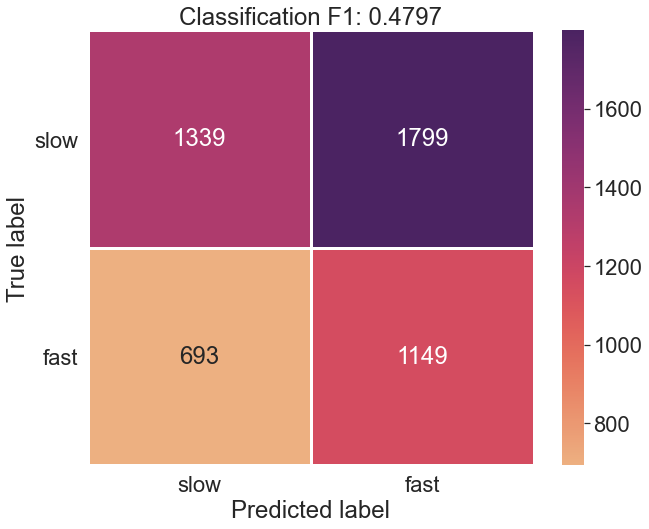

In [23]:
rf_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=RNG_SEED))
])

rf_clf_params = {
    "model__n_estimators": randint(10, 500),
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": randint(5, 100),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__bootstrap": [True, False],
    "model__class_weight": ['balanced', 'balanced_subsample']
}

rf_clf_random_cv = randomized_search(rf_clf, rf_clf_params, X_train, y_train, regression=False)
best_rf_clf =  rf_clf_random_cv.best_estimator_
struct_class_results["rf"] = score_summary(best_rf_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_rf_clf, X_test, y_test, name="struct_class_rf")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.7226763856207272, 'model__loss': 'exponential', 'model__max_depth': 65, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 379, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.637676,0.000708,0.598645,0.002618
Precision,0.643818,0.013095,0.396996,0.010692
Recall,0.129603,0.010443,0.084488,0.006598
F1 Score,0.215474,0.013761,0.139184,0.008997
ROC AUC,0.628902,0.002160,0.535470,0.009408



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.634388,0.616667
Recall,0.110473,0.064604
Precision,0.642369,0.390164
F1 Score,0.188524,0.110852
ROC AUC,0.536031,0.502665


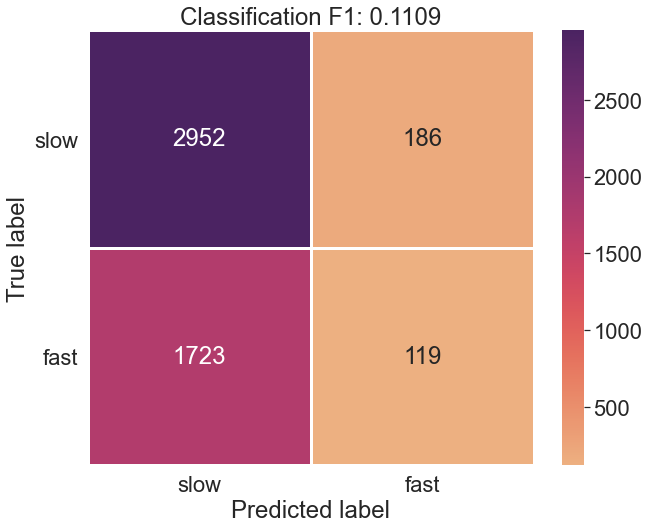

In [24]:
gb_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingClassifier(random_state=RNG_SEED))
])

gb_clf_params = {
    "model__n_estimators": randint(10, 500),
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__loss": ["deviance", "exponential"],
    "model__max_depth": randint(1, 100),
    "model__learning_rate": uniform(0.1, 0.8),
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__warm_start": [True, False],
}

gb_clf_random_cv = randomized_search(gb_clf, gb_clf_params, X_train, y_train, regression=False)
best_gb_clf =  gb_clf_random_cv.best_estimator_
struct_class_results["gb"] = score_summary(best_gb_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_gb_clf, X_test, y_test, name="struct_class_gb")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 20.273255210020587, 'model__gamma': 0.9672042018045066}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.637613,0.000717,0.599347,0.003165
Precision,0.651537,0.014317,0.394099,0.019108
Recall,0.124086,0.009039,0.078612,0.007618
F1 Score,0.208227,0.012127,0.130972,0.011216
ROC AUC,0.551321,0.006939,0.505823,0.006208



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.634337,0.617068
Recall,0.106033,0.060803
Precision,0.649600,0.387543
F1 Score,0.182308,0.105115
ROC AUC,0.535156,0.502199


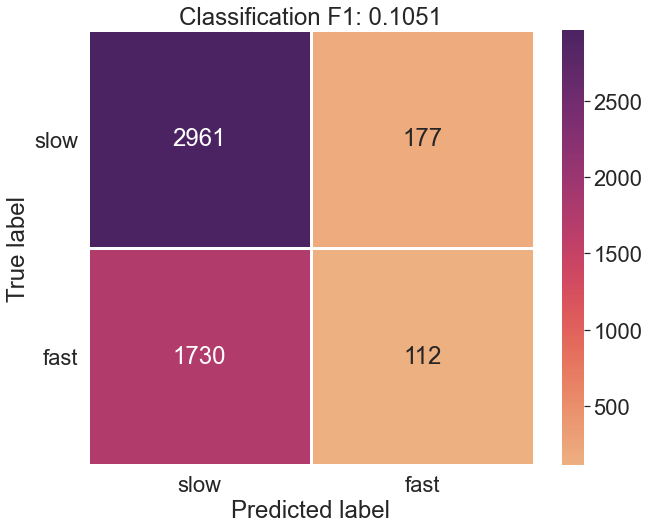

In [25]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", random_state=RNG_SEED)),
])

svm_clf_params = {
    "model__C": uniform(1, 20),
    "model__gamma": expon(scale=2)
}

svm_clf_random_cv = randomized_search(svm_clf, svm_clf_params, X_train, y_train, iters=20, regression=False)
best_svm_clf = svm_clf_random_cv.best_estimator_
struct_class_results["svm"] = score_summary(best_svm_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_svm_clf, X_test, y_test, name="struct_class_svm")

In [26]:
# save stuff
import dill as pickle

pickle.dump(struct_results, open("model_saves/struct_results.pkl", "wb"))
pickle.dump(struct_class_results, open("model_saves/struct_class_results.pkl", "wb"))

## Coordination Numbers and Changes in Coordination as Features

In [93]:
X = data[structure + flips]
y = data['dr']

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
results = {}

### Dummy


Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.000000,-0.000267
MAE,1.405208,1.417903
MSE,3.254197,3.293851
RMSE,1.803939,1.814897


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


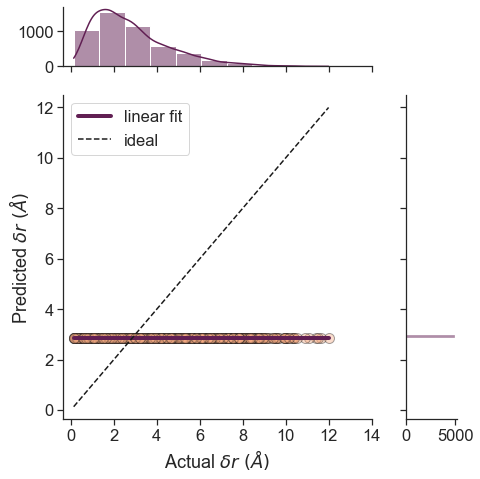

In [102]:
dummy.fit(X_train, y_train)

results["dummy"] = score_summary(dummy, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, dummy.predict(X_test), save_name="actpred_dummy")

### Linear (Polynomial Ridge)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 4.656005689076002}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.150740,0.001255,0.143545,0.005684
MAE,1.286756,0.003319,1.292417,0.014434
MSE,2.798165,0.014624,2.820486,0.058444
RMSE,1.672766,0.004370,1.679340,0.017415



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.150102,0.137568
MAE,1.287315,1.273335
MSE,2.800354,2.697960
RMSE,1.673426,1.642547


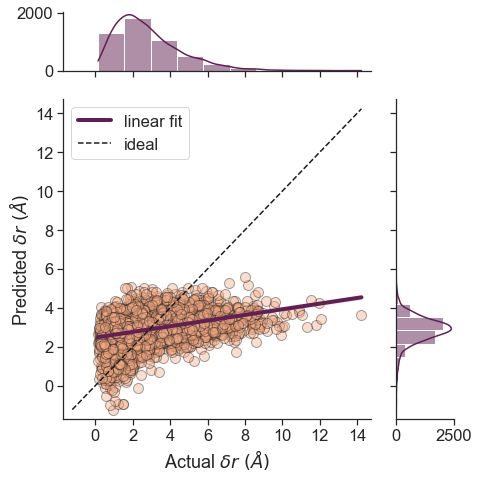

In [29]:
linear_random_cv = randomized_search(linear, linear_params, X_train, y_train)
best_linear = linear_random_cv.best_estimator_
results["ridge"] = score_summary(best_linear, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_linear.predict(X_test), save_name="actpred_ridge")

### Nearest Neighbors Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 18, 'model__n_neighbors': 14, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.192243,0.002322,0.070365,0.012508
MAE,1.269319,0.004273,1.363430,0.017070
MSE,2.661413,0.014309,3.061257,0.062504
RMSE,1.631378,0.004385,1.749553,0.017887



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.196156,0.056332
MAE,1.264936,1.344073
MSE,2.648611,2.952093
RMSE,1.627455,1.718166


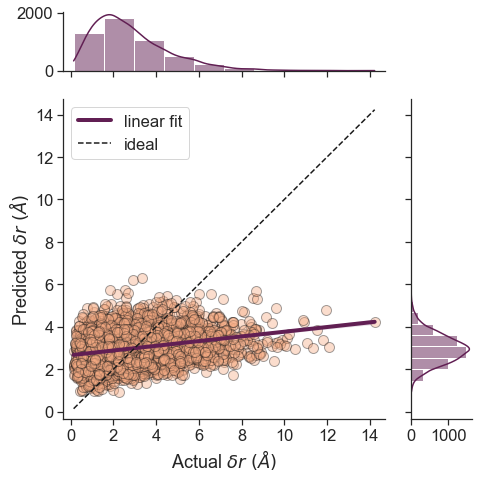

In [30]:
knr_random_cv = randomized_search(knr, knr_params, X_train, y_train)
best_knr = knr_random_cv.best_estimator_
results["knn"] = score_summary(best_knr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_knr.predict(X_test), save_name="actpred_knn")

### Tree-Based Models

#### Decision Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 5, 'model__max_features': 'auto', 'model__min_samples_leaf': 6, 'model__min_samples_split': 7, 'model__splitter': 'best'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.101137,0.002391,0.081827,0.005979
MAE,1.327394,0.004338,1.343384,0.014673
MSE,2.961621,0.020383,3.023765,0.063833
RMSE,1.720926,0.005920,1.738801,0.018370



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.098075,0.077068
MAE,1.330596,1.320594
MSE,2.971781,2.887224
RMSE,1.723885,1.699183


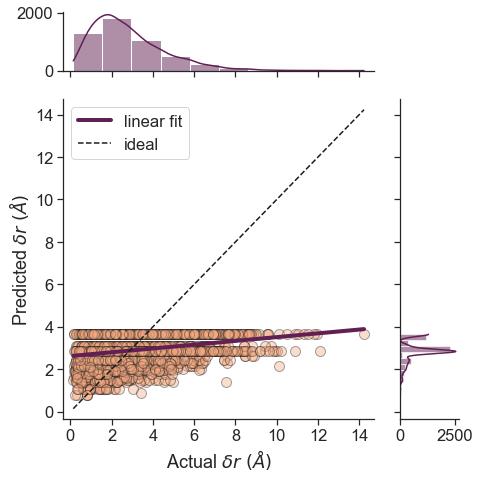

In [31]:
dtr_random_cv = randomized_search(dtr, dtr_params, X_train, y_train)
best_dtr = dtr_random_cv.best_estimator_
results["dtr"] = score_summary(best_dtr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_dtr.predict(X_test), save_name="actpred_dtr")

#### Extra Trees Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__max_depth': 8, 'model__max_features': 'auto', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.113186,0.003894,0.077207,0.017136
MAE,1.315945,0.006107,1.345992,0.020825
MSE,2.921984,0.029560,3.038487,0.062365
RMSE,1.709359,0.008643,1.743033,0.017934



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.118346,0.084945
MAE,1.312411,1.311801
MSE,2.904989,2.862583
RMSE,1.704403,1.691917


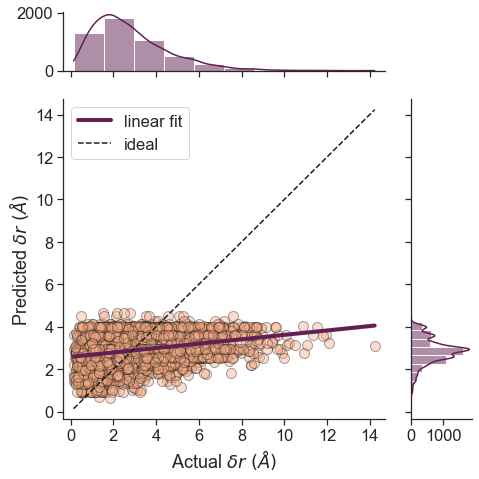

In [32]:
etr_random_cv = randomized_search(etr, etr_params, X_train, y_train)
best_etr = etr_random_cv.best_estimator_
results["etr"] = score_summary(best_etr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_etr.predict(X_test), save_name="actpred_etr")

### Support Vector Regression

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 2, 'model__epsilon': 0.4166900152330658}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.182001,0.001819,0.131396,0.004117
MAE,1.194278,0.003328,1.248461,0.013621
MSE,2.695177,0.016984,2.860758,0.069220
RMSE,1.641691,0.005174,1.691253,0.020533



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.179680,0.129127
MAE,1.197364,1.234463
MSE,2.702897,2.724367
RMSE,1.644049,1.650566


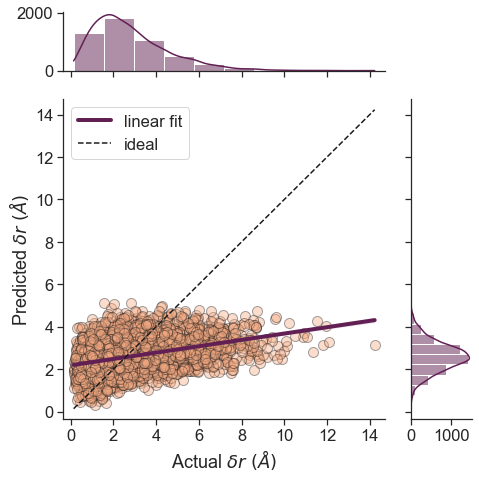

In [33]:
svr_random_cv = randomized_search(svr, svr_params, X_train, y_train, iters=20)
best_svr = svr_random_cv.best_estimator_
results["svr"] = score_summary(best_svr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_svr.predict(X_test), save_name="actpred_svr")

### Ensemble Methods
#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': True, 'model__max_depth': 65, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 370}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.406378,0.001392,0.145684,0.007184
MAE,1.066532,0.002596,1.287140,0.015584
MSE,1.955881,0.010595,2.813585,0.066419
RMSE,1.398523,0.003787,1.677257,0.019801



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.406748,0.141026
MAE,1.065429,1.266903
MSE,1.954723,2.687144
RMSE,1.398114,1.639251


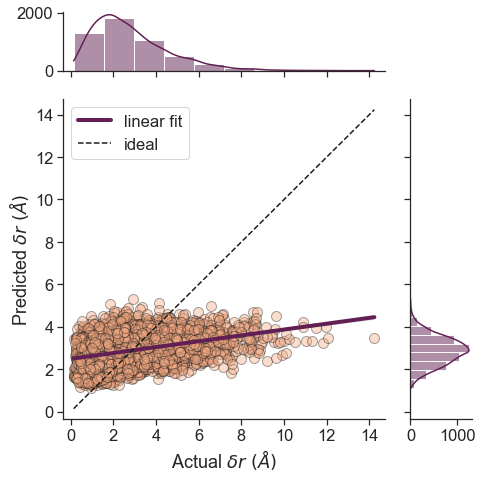

In [34]:
rf_random_cv = randomized_search(rfr, rfr_params, X_train, y_train)
best_rfr = rf_random_cv.best_estimator_
results["rfr"] = score_summary(best_rfr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_rfr.predict(X_test), save_name="actpred_rfr")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.44513474834717914, 'model__max_depth': 4, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 301, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
R2,0.428037,0.002443,0.089126,0.018823
MAE,1.033977,0.001617,1.326962,0.014303
MSE,1.884488,0.005810,2.999089,0.060351
RMSE,1.372765,0.002116,1.731699,0.017494



Score summary on full training data and test data:


,Training Scores,Test Scores
R2,0.389444,0.075006
MAE,1.070789,1.305429
MSE,2.011739,2.893676
RMSE,1.418358,1.701081


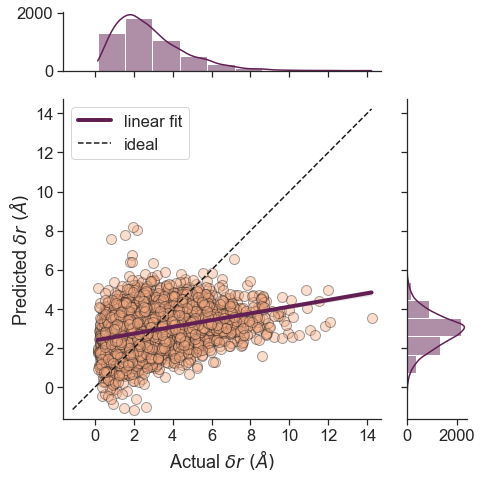

In [35]:
gbr_random_cv = randomized_search(gbr, gbr_params, X_train, y_train)
best_gbr = gbr_random_cv.best_estimator_
results["gbr"] = score_summary(best_gbr, X_train, X_test, y_train, y_test)
plot_pred_act(y_test, best_gbr.predict(X_test), save_name="actpred_gbr")

### Classification

In [155]:
X = data[structure + flips]
y = df['fast']

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)
class_results = {}

#### Dummy


Score summary on full training data and test data:


C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khanm\anaconda3\envs\mse7050\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Training Scores,Test Scores
Accuracy,0.615562,0.63012
Recall,0.000000,0.00000
Precision,0.000000,0.00000
F1 Score,0.000000,0.00000
ROC AUC,0.500000,0.50000


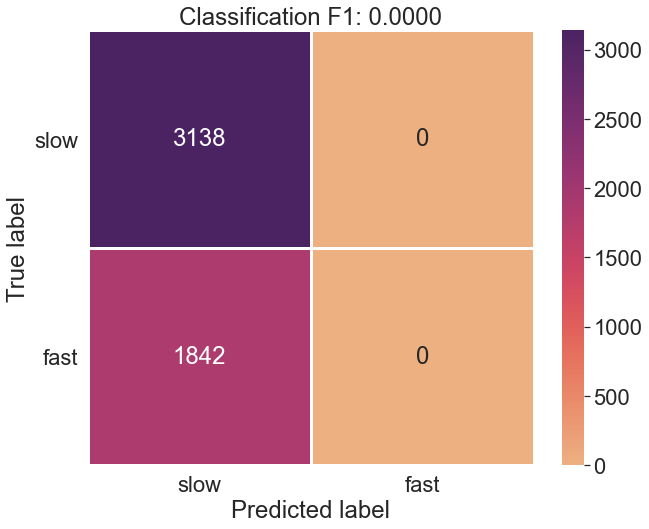

In [37]:
dummy_clf.fit(X_train, y_train)
class_results["dummy"] = score_summary(dummy_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(dummy_clf, X_test, y_test, name="class_dummy")

#### Ridge

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__alpha': 0.0196282248134428}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.657593,0.000737,0.652811,0.005473
Precision,0.602187,0.002315,0.591581,0.016124
Recall,0.322212,0.005220,0.314311,0.006708
F1 Score,0.419769,0.004200,0.410391,0.006504
ROC AUC,0.696259,0.001550,0.688560,0.007656



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.656526,0.658032
Recall,0.319796,0.313246
Precision,0.599951,0.568473
F1 Score,0.417206,0.403920
ROC AUC,0.593310,0.586834


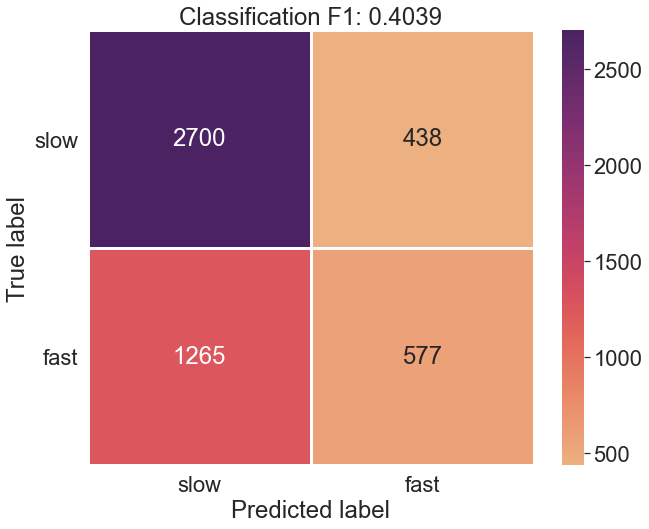

In [38]:
# perform a randomized hyperparameter search and print out CV scoring metrics
ridge_clf_random_cv = randomized_search(ridge_clf, ridge_clf_params, X_train, y_train, regression=False)
best_ridge_clf = ridge_clf_random_cv.best_estimator_
# print out a score summary on full training set and test set
class_results["ridge"] = score_summary(best_ridge_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_ridge_clf, X_test, y_test, name="class_ridge")

#### Decision Tree

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'entropy', 'model__max_depth': 69, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 19, 'model__splitter': 'best'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.812262,0.001105,0.600251,0.004706
Precision,0.790935,0.005583,0.477561,0.006548
Recall,0.695612,0.005507,0.422431,0.023045
F1 Score,0.740178,0.001228,0.447956,0.013750
ROC AUC,0.901015,0.001579,0.599779,0.005624



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.810843,0.602811
Recall,0.693654,0.414224
Precision,0.788833,0.459085
F1 Score,0.738188,0.435502
ROC AUC,0.788843,0.563868


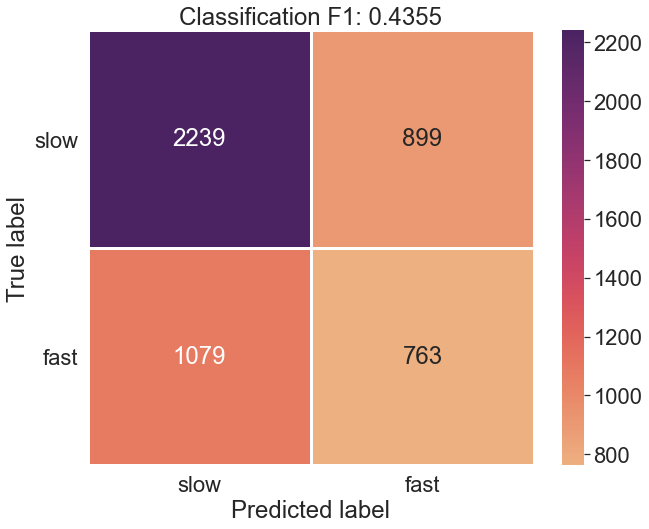

In [39]:
# perform a randomized hyperparameter search and print out CV scoring metrics
dt_clf_random_cv = randomized_search(dt_clf, dt_clf_params, X_train, y_train, regression=False)
best_dt_clf = dt_clf_random_cv.best_estimator_
# print out a score summary on full training set and test set
class_results["dt"] = score_summary(best_dt_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_dt_clf, X_test, y_test, name="_class_dt")

#### Extra Trees

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__criterion': 'entropy', 'model__max_depth': 69, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 19, 'model__splitter': 'best'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.812262,0.001105,0.600251,0.004706
Precision,0.790935,0.005583,0.477561,0.006548
Recall,0.695612,0.005507,0.422431,0.023045
F1 Score,0.740178,0.001228,0.447956,0.013750
ROC AUC,0.901015,0.001579,0.599779,0.005624



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.810843,0.602811
Recall,0.693654,0.414224
Precision,0.788833,0.459085
F1 Score,0.738188,0.435502
ROC AUC,0.788843,0.563868


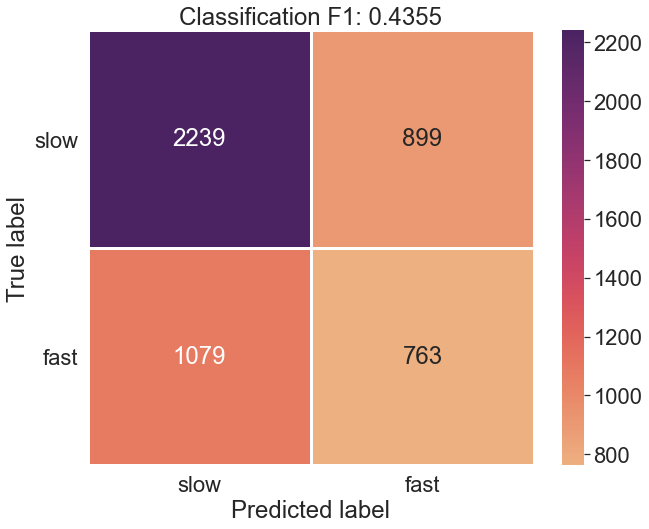

In [40]:
# perform a randomized hyperparameter search and print out CV scoring metrics
et_clf_random_cv = randomized_search(et_clf, et_clf_params, X_train, y_train, regression=False)
best_et_clf = et_clf_random_cv.best_estimator_

# print out a score summary on full training set and test set
class_results["et"] = score_summary(best_et_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_et_clf, X_test, y_test, name="class_et")

#### Nearest Neighbors

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__leaf_size': 31, 'model__n_neighbors': 3, 'model__weights': 'uniform'}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.791792,0.001547,0.596386,0.006892
Precision,0.745800,0.001691,0.473846,0.009398
Recall,0.695449,0.004364,0.452597,0.013416
F1 Score,0.719738,0.002677,0.462941,0.011021
ROC AUC,0.855184,0.001372,0.589022,0.010178



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.792219,0.595382
Recall,0.695090,0.456026
Precision,0.746878,0.453319
F1 Score,0.720054,0.454668
ROC AUC,0.773984,0.566604


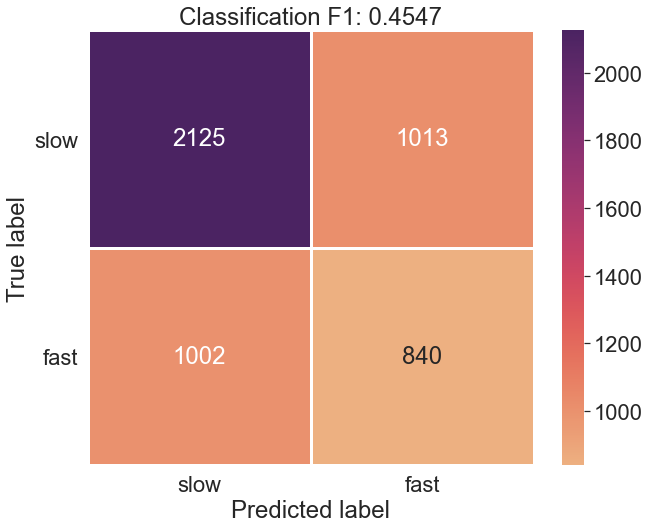

In [41]:
knn_clf_random_cv = randomized_search(knn_clf, knn_clf_params, X_train, y_train, regression=False)
best_knn_clf =  knn_clf_random_cv.best_estimator_
class_results["knn"] = score_summary(best_knn_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_knn_clf, X_test, y_test, name="class_knn")

#### Random Forests

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 254}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.673845,0.001334,0.623042,0.007889
Precision,0.556158,0.001173,0.507349,0.007660
Recall,0.750718,0.008440,0.676545,0.014345
F1 Score,0.638936,0.003242,0.579795,0.008610
ROC AUC,0.758828,0.002168,0.685183,0.006890



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.666064,0.607229
Recall,0.743144,0.672638
Precision,0.548477,0.478009
F1 Score,0.631141,0.558863
ROC AUC,0.680535,0.620736


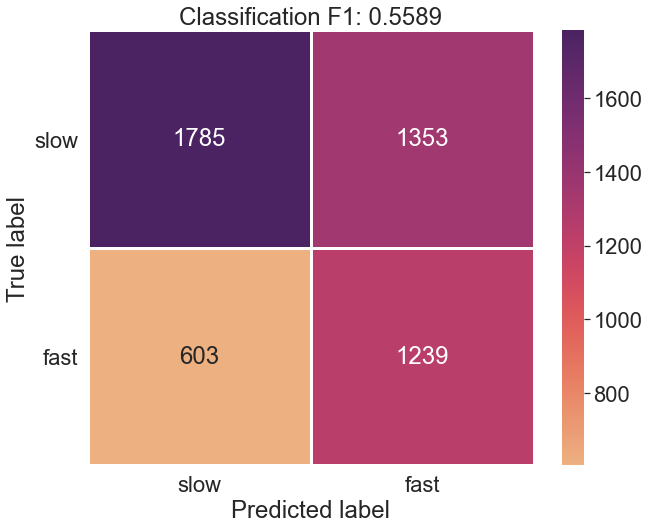

In [42]:
rf_clf_random_cv = randomized_search(rf_clf, rf_clf_params, X_train, y_train, regression=False)
best_rf_clf =  rf_clf_random_cv.best_estimator_
class_results["rf"] = score_summary(best_rf_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_rf_clf, X_test, y_test, name="class_rf")

#### Gradient Boosting

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__learning_rate': 0.395846474198672, 'model__loss': 'deviance', 'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 306, 'model__warm_start': True}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.736044,0.000868,0.649147,0.005377
Precision,0.700250,0.002879,0.556765,0.008590
Recall,0.548022,0.005484,0.427785,0.018405
F1 Score,0.614827,0.002712,0.483674,0.013921
ROC AUC,0.810410,0.001972,0.680932,0.007049



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.724699,0.647590
Recall,0.525986,0.412595
Precision,0.684801,0.530356
F1 Score,0.594978,0.464122
ROC AUC,0.687394,0.599064


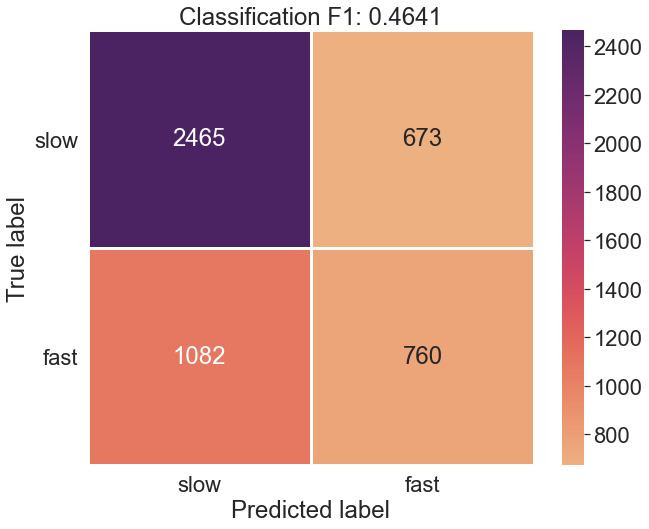

In [43]:
gb_clf_random_cv = randomized_search(gb_clf, gb_clf_params, X_train, y_train, regression=False)
best_gb_clf =  gb_clf_random_cv.best_estimator_
class_results["gb"] = score_summary(best_gb_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_gb_clf, X_test, y_test, name="class_gb")

#### Support Vector Machine

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 20.273255210020587, 'model__gamma': 0.9672042018045066}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.950816,0.001553,0.597390,0.001938
Precision,0.957805,0.001518,0.472433,0.003664
Recall,0.912249,0.003013,0.406500,0.015080
F1 Score,0.934471,0.002128,0.436891,0.010228
ROC AUC,0.980824,0.001196,0.587677,0.010275



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.943825,0.589759
Recall,0.896709,0.402280
Precision,0.954413,0.440285
F1 Score,0.924662,0.420426
ROC AUC,0.934980,0.551044


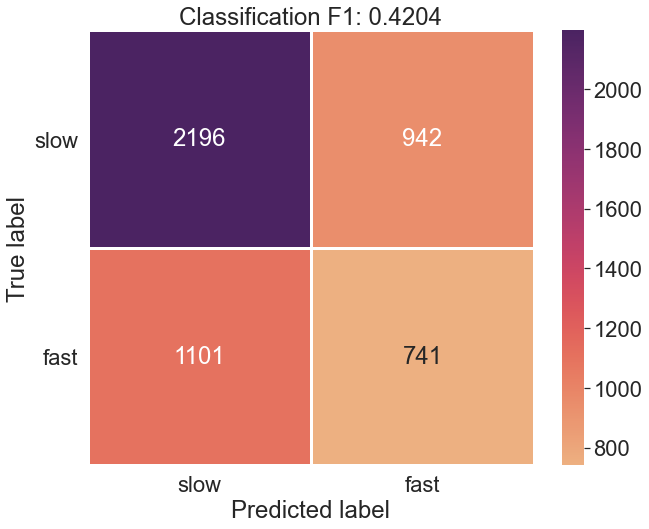

In [44]:
svm_clf_random_cv = randomized_search(svm_clf, svm_clf_params, X_train, y_train, iters=20, regression=False)
best_svm_clf = svm_clf_random_cv.best_estimator_
class_results["svm"] = score_summary(best_svm_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_svm_clf, X_test, y_test, name="class_svm")

In [103]:
import dill as pickle

pickle.dump(best_rfr, open("model_saves/best_rfr.pkl", "wb"))
pickle.dump(best_rf_clf, open("model_saves/best_rf_clf.pkl", "wb"))
pickle.dump(best_linear, open("model_saves/best_ridge.pkl", "wb"))
pickle.dump(best_ridge_clf, open("model_saves/best_ridge_clf.pkl", "wb"))

pickle.dump(results, open("model_saves/results.pkl", "wb"))
pickle.dump(class_results, open("model_saves/class_results.pkl", "wb"))

In [46]:
def plot_impurity_feature_importance(pipeline, title=""):
    """
    Plots the impurity-based feature importances of a tree-based model

    Args:
        pipeline (Pipeline): sklearn pipeline containing a tree-based model with "model" as step name
        title (str, optional): Model name for the barchart title. Defaults to "".
    """
    sns.set(style="darkgrid", font_scale=1.2)
    # retrieve built-in feature importances for the tree-based model
    tree_feature_importances = pipeline["model"].feature_importances_
    # sort feature importances for plotting
    sorted_idx = tree_feature_importances.argsort()[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=tree_feature_importances[sorted_idx],
        y=X.columns[sorted_idx],
        palette="flare_r",
    )
    plt.xlabel("Mean Decrease in Impurity (Gini Importance)")
    plt.title(f"{title} Feature Importance")
    plt.show()


def plot_permutation_importance(model, X_test, y_test, n_repeats=100, save=True, save_name=""):
    """
    Plots the permutation-based feature importance of a fitted model on a test/holdout data set.
    Feature importance is defined by the decrease in mean squared error when feature is removed.

    Args:
        model (sklearn estimator): fitted estimator or pipeline
        X_test (DataFrame): features for regression, with feature names as column names
        y_test (array-like): labels for regression
        n_repeats (int, optional): Number of times to permute a feature. Defaults to 100.
        title (str, optional): Model name for the boxplot title. Defaults to "".
        save (bool, optional): Whether to save plot image. Defaults to True.
        save_name (str, optional): Filename for saved plot image. Defaults to "act_pred".
    """
    sns.set(style="darkgrid", font_scale=1.2)
    # Calculate permutation importance based on the decrease in model MSE when a feature is permuted
    pi_results = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=RNG_SEED,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    # sort feature importances for plotting
    sorted_idx = pi_results.importances_mean.argsort()[::-1]
    # feature_importances = result.importances[sorted_idx].T
    df_pi = pd.DataFrame(pi_results.importances[sorted_idx].T, columns=X_test.columns)

    plt.figure(figsize=(10, 6))
    # create a boxplot of feature importances
    sns.boxplot(data=df_pi, orient="horizontal", linewidth=1, palette="flare_r")
    # plt.title(f"{title} Permutation Feature Importance")
    plt.xlabel("Feature Permutation Importance (Decrease in MSE)")
    plt.show()

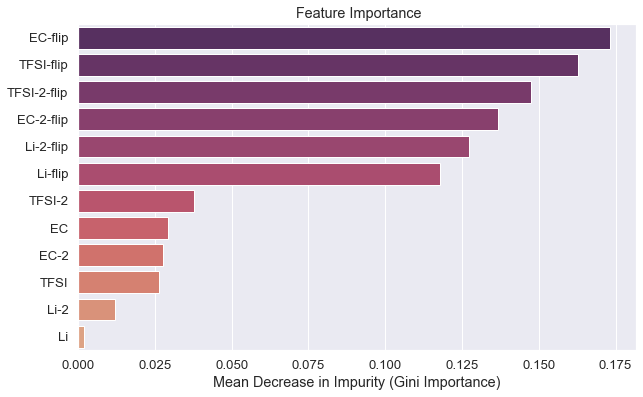

In [47]:
plot_impurity_feature_importance(best_rfr)

In [48]:
X = data[structure + flips]
y = data['dr']

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)

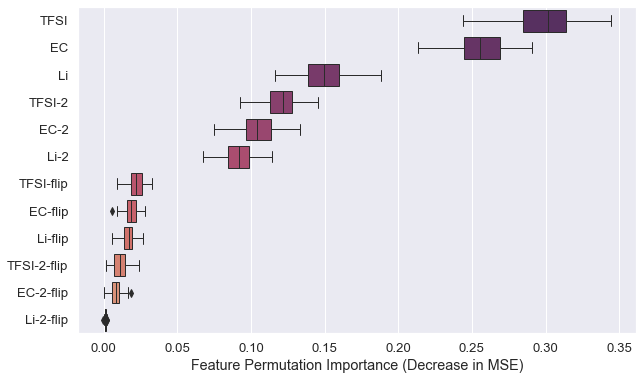

In [49]:
plot_permutation_importance(best_rfr, X_test, y_test)

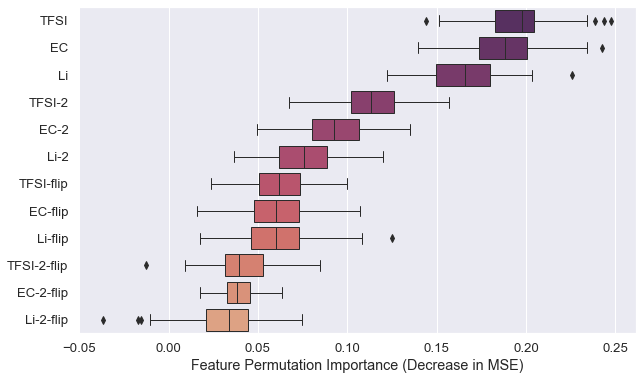

In [50]:
plot_permutation_importance(best_knr, X_test, y_test)

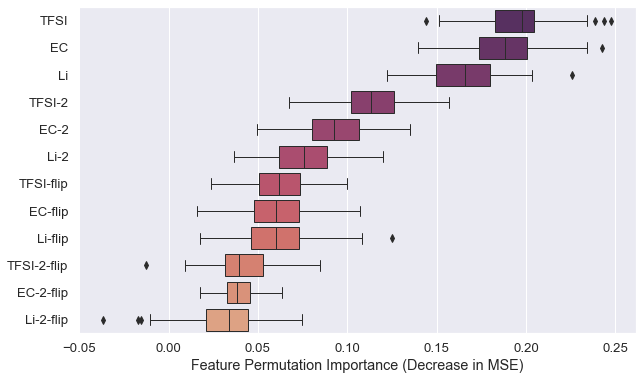

In [51]:
plot_permutation_importance(best_knr, X_test, y_test)

### Classification Feature Importances

In [52]:
X = data[structure + flips]
y = df['fast']

# create training and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)

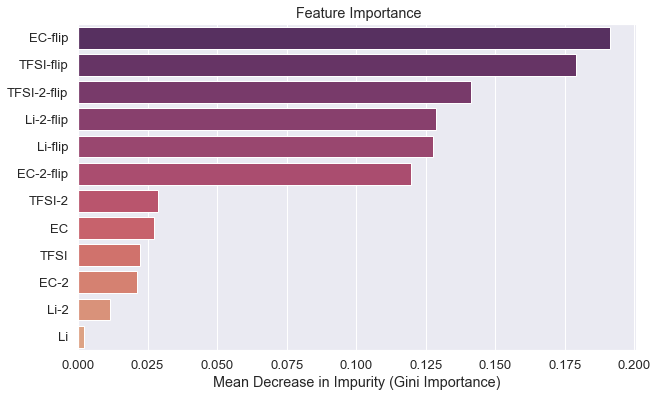

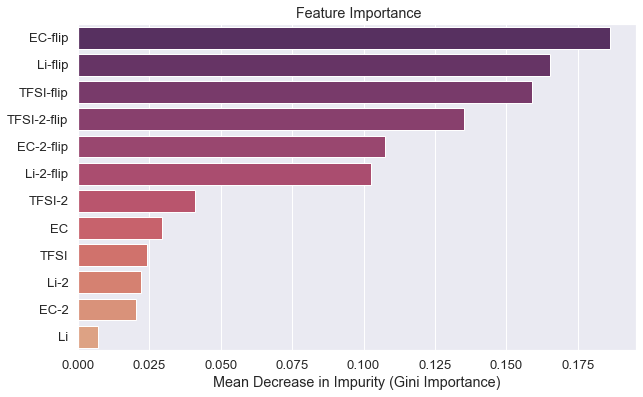

In [53]:
plot_impurity_feature_importance(best_rf_clf)
plot_impurity_feature_importance(best_gb_clf)

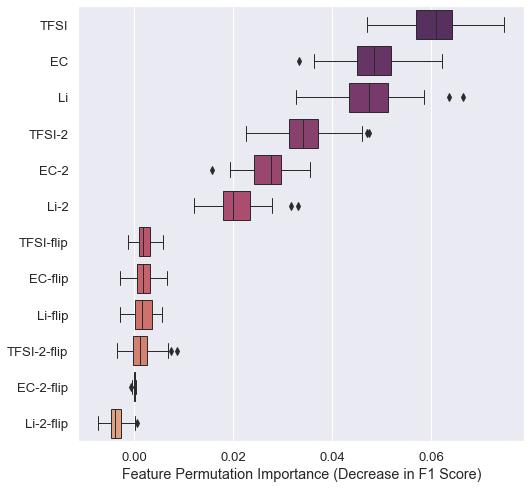

In [54]:
sns.set(style="darkgrid", font_scale=1.2)
# Calculate permutation importance based on the decrease in model MSE when a feature is permuted
pi_results = permutation_importance(
    estimator=best_rf_clf,
    X=X_test,
    y=y_test,
    n_repeats=100,
    random_state=RNG_SEED,
    scoring="f1",
    n_jobs=-1,
)
# sort feature importances for plotting
sorted_idx = pi_results.importances_mean.argsort()[::-1]
# feature_importances = result.importances[sorted_idx].T
df_pi = pd.DataFrame(pi_results.importances[sorted_idx].T, columns=X_test.columns)

plt.figure(figsize=(8, 8))
# create a boxplot of feature importances
sns.boxplot(data=df_pi, orient="horizontal", linewidth=1, palette="flare_r")
# plt.title(f"{title} Permutation Feature Importance")
plt.xlabel("Feature Permutation Importance (Decrease in F1 Score)")
plt.savefig(f"figures/rf_clf_permutation.png", dpi=300, bbox_inches="tight")
plt.show()

In [55]:
X.corr()

,TFSI,EC,Li,TFSI-2,EC-2,Li-2,TFSI-flip,EC-flip,Li-flip,TFSI-2-flip,EC-2-flip,Li-2-flip
TFSI,1.000000,-0.869745,-0.006907,0.683439,-0.160365,0.110895,0.540887,-0.353251,0.004155,0.220165,-0.319462,0.154673
EC,-0.869745,1.000000,0.106309,-0.699577,0.085389,-0.109455,-0.506633,0.378750,0.045165,-0.225340,0.343074,-0.147674
Li,-0.006907,0.106309,1.000000,0.071965,0.158909,-0.053425,0.033241,0.166953,0.312255,0.063960,0.102063,0.165793
TFSI-2,0.683439,-0.699577,0.071965,1.000000,-0.101920,0.294859,0.591375,-0.252829,0.113315,0.430272,-0.225868,0.305254
EC-2,-0.160365,0.085389,0.158909,-0.101920,1.000000,0.414231,-0.069456,0.428054,0.307659,0.018516,0.484946,0.329369
Li-2,0.110895,-0.109455,-0.053425,0.294859,0.414231,1.000000,0.193539,0.210458,0.362425,0.265757,0.230704,0.517364
TFSI-flip,0.540887,-0.506633,0.033241,0.591375,-0.069456,0.193539,1.000000,-0.127677,0.142157,0.558591,-0.130508,0.249839
EC-flip,-0.353251,0.378750,0.166953,-0.252829,0.428054,0.210458,-0.127677,1.000000,0.496411,0.008455,0.669586,0.271475
Li-flip,0.004155,0.045165,0.312255,0.113315,0.307659,0.362425,0.142157,0.496411,1.000000,0.212171,0.313711,0.539461
TFSI-2-flip,0.220165,-0.225340,0.063960,0.430272,0.018516,0.265757,0.558591,0.008455,0.212171,1.000000,-0.002177,0.438008


## Making those tables

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'model__bootstrap': False, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 11, 'model__min_samples_leaf': 9, 'model__min_samples_split': 9, 'model__n_estimators': 277}

Mean and standard deviation of performance on 5-fold cross-validation:


,Mean (Train),STD (Train),Mean (Val),STD (Val)
Accuracy,0.713291,0.003293,0.618273,0.006602
Precision,0.590518,0.004043,0.502975,0.006312
Recall,0.831169,0.008227,0.695293,0.016759
F1 Score,0.690440,0.002727,0.583531,0.004046
ROC AUC,0.818043,0.002169,0.685037,0.004692



Score summary on full training data and test data:


,Training Scores,Test Scores
Accuracy,0.655321,0.650201
Recall,0.730262,0.726184
Precision,0.538336,0.518461
F1 Score,0.619781,0.604989
ROC AUC,0.669365,0.665987


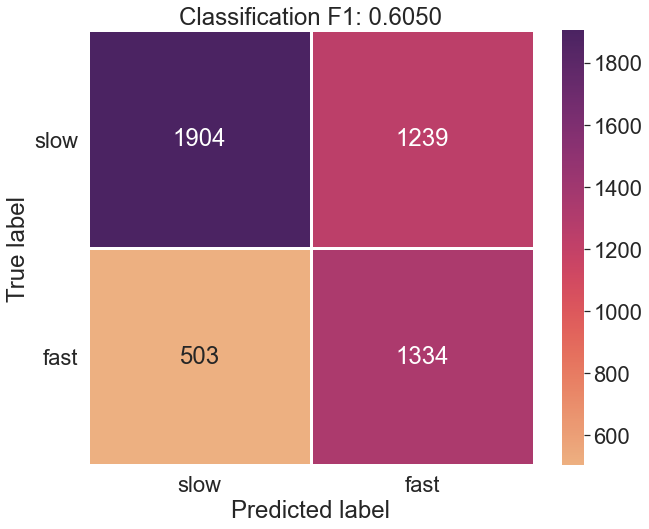

In [159]:
pipe = Pipeline([
    ("poly", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=RNG_SEED))
])

randomized_search(pipe, rf_clf_params, X_train, y_train, regression=False)
best_rf_clf =  rf_clf_random_cv.best_estimator_
score_summary(best_rf_clf, X_train, X_test, y_train, y_test, regression=False)
plot_confusion_matrix(best_rf_clf, X_test, y_test, save=False)

In [119]:
struct_results[key]['Test Scores'].rename(name)

R2     -0.017369
MAE     1.386724
MSE     3.182653
RMSE    1.783999
Name: Gradient Boosting, dtype: float64

In [160]:
X.shape

(24900, 12)

## Regression Results Using Structural Features Only

In [144]:
keys = struct_results.keys()
names = [
    "Dummy",
    "Polynomial Ridge",
    "KNN",
    "Decision Tree",
    "Extra Trees",
    "SVM",
    "Random Forest",
    "Gradient Boosting",
]

reg_results_struct = []
for key, name in zip(keys, names):
    reg_results_struct.append(struct_results[key]["Test Scores"].rename(name))

reg_results_struct = pd.concat(reg_results_struct, axis="columns").T
reg_results_struct.to_csv("tables/reg_results_struct.csv")
reg_results_struct

,R2,MAE,MSE,RMSE
Dummy,-0.000969,1.381654,3.131351,1.769562
Polynomial Ridge,0.006969,1.375519,3.106518,1.762532
KNN,-0.079234,1.431201,3.376188,1.837441
Decision Tree,0.003633,1.376459,3.116953,1.765489
Extra Trees,0.003633,1.376459,3.116953,1.765489
SVM,-0.024943,1.331359,3.206348,1.790628
Random Forest,0.006938,1.374103,3.106614,1.762559
Gradient Boosting,-0.017369,1.386724,3.182653,1.783999


## Classification Results Using Structural Features Only

In [146]:
keys = struct_class_results.keys()
class_names = [
    "Dummy",
    "Polynomial Ridge",
    "Decision Tree",
    "Extra Trees",
    "KNN",
    "Random Forest",
    "Gradient Boosting",
    "SVM",
]
clf_results_struct = []
for key, name in zip(keys, class_names):
    clf_results_struct.append(
        struct_class_results[key]["Test Scores"].rename(name)
    )
clf_results_struct = pd.concat(
    clf_results_struct, axis="columns"
).T.reindex(names)
clf_results_struct.to_csv("tables/clf_results_struct.csv")
clf_results_struct

,Accuracy,Recall,Precision,F1 Score,ROC AUC
Dummy,0.630120,0.000000,0.000000,0.000000,0.500000
Polynomial Ridge,0.629518,0.002714,0.384615,0.005391,0.500083
KNN,0.550201,0.282845,0.361806,0.317489,0.494992
Decision Tree,0.619277,0.052660,0.391129,0.092823,0.502270
Extra Trees,0.619277,0.052660,0.391129,0.092823,0.502270
SVM,0.617068,0.060803,0.387543,0.105115,0.502199
Random Forest,0.499598,0.623779,0.389756,0.479749,0.525242
Gradient Boosting,0.616667,0.064604,0.390164,0.110852,0.502665


## Regression Results Using All Features

In [147]:
results.keys()

dict_keys(['ridge', 'knn', 'dtr', 'etr', 'svr', 'rfr', 'gbr', 'dummy'])

In [148]:
keys = results.keys()
temp_names = [
    "Polynomial Ridge",
    "KNN",
    "Decision Tree",
    "Extra Trees",
    "SVM",
    "Random Forest",
    "Gradient Boosting",
    "Dummy",
]

reg_results = []
for key, name in zip(keys, temp_names):
    reg_results.append(results[key]["Test Scores"].rename(name))

reg_results = pd.concat(reg_results, axis="columns").T.reindex(names)
reg_results.to_csv("tables/reg_results.csv")
reg_results

,R2,MAE,MSE,RMSE
Dummy,-0.000267,1.417903,3.293851,1.814897
Polynomial Ridge,0.137568,1.273335,2.697960,1.642547
KNN,0.056332,1.344073,2.952093,1.718166
Decision Tree,0.077068,1.320594,2.887224,1.699183
Extra Trees,0.084945,1.311801,2.862583,1.691917
SVM,0.129127,1.234463,2.724367,1.650566
Random Forest,0.141026,1.266903,2.687144,1.639251
Gradient Boosting,0.075006,1.305429,2.893676,1.701081


## Classification Results Using All Features

In [149]:
class_results.keys()

dict_keys(['dummy', 'ridge', 'dt', 'et', 'knn', 'rf', 'gb', 'svm'])

In [150]:
class_names

['Dummy',
 'Polynomial Ridge',
 'Decision Tree',
 'Extra Trees',
 'KNN',
 'Random Forest',
 'Gradient Boosting',
 'SVM']

In [151]:
keys = class_results.keys()

clf_results = []
for key, name in zip(keys, class_names):
    clf_results.append(class_results[key]["Test Scores"].rename(name))

clf_results = pd.concat(clf_results, axis="columns").T.reindex(names)
clf_results.to_csv("tables/clf_results.csv")
clf_results

,Accuracy,Recall,Precision,F1 Score,ROC AUC
Dummy,0.630120,0.000000,0.000000,0.000000,0.500000
Polynomial Ridge,0.658032,0.313246,0.568473,0.403920,0.586834
KNN,0.595382,0.456026,0.453319,0.454668,0.566604
Decision Tree,0.602811,0.414224,0.459085,0.435502,0.563868
Extra Trees,0.602811,0.414224,0.459085,0.435502,0.563868
SVM,0.589759,0.402280,0.440285,0.420426,0.551044
Random Forest,0.607229,0.672638,0.478009,0.558863,0.620736
Gradient Boosting,0.647590,0.412595,0.530356,0.464122,0.599064


In [115]:
results['dummy']['Test Scores']

R2     -0.000267
MAE     1.417903
MSE     3.293851
RMSE    1.814897
Name: Test Scores, dtype: float64

In [111]:
keys = struct_class_results.keys()
class_model_names = ["Dummy", "Polynomial Ridge", "Decision Tree", "Extra Trees", "KNN", "Random Forest", "Gradient Boosting", "SVM"]

test_class_results = []
for key, name in zip(keys, class_model_names):
    test_class_results.append(struct_class_results[key]['Test Scores'].rename(name))

pd.concat(test_class_results, axis='columns').T

,Accuracy,Recall,Precision,F1 Score,ROC AUC
Dummy,0.630120,0.000000,0.000000,0.000000,0.500000
Polynomial Ridge,0.629518,0.002714,0.384615,0.005391,0.500083
Decision Tree,0.619277,0.052660,0.391129,0.092823,0.502270
Extra Trees,0.619277,0.052660,0.391129,0.092823,0.502270
KNN,0.550201,0.282845,0.361806,0.317489,0.494992
Random Forest,0.499598,0.623779,0.389756,0.479749,0.525242
Gradient Boosting,0.616667,0.064604,0.390164,0.110852,0.502665
SVM,0.617068,0.060803,0.387543,0.105115,0.502199


In [63]:
keys = struct_class_results.keys()
class_model_names = ["Dummy", "Polynomial Ridge", "Decision Tree", "Extra Trees", "KNN", "Random Forest", "Gradient Boosting", "SVM"]

test_class_results = []
for key, name in zip(keys, class_model_names):
    test_class_results.append(struct_class_results[key]['Test Scores'].rename(name))

pd.concat(test_class_results, axis='columns').T

,Accuracy,Recall,Precision,F1 Score,ROC AUC
Dummy,0.630120,0.000000,0.000000,0.000000,0.500000
Polynomial Ridge,0.629518,0.002714,0.384615,0.005391,0.500083
Decision Tree,0.619277,0.052660,0.391129,0.092823,0.502270
Extra Trees,0.619277,0.052660,0.391129,0.092823,0.502270
KNN,0.550201,0.282845,0.361806,0.317489,0.494992
Random Forest,0.499598,0.623779,0.389756,0.479749,0.525242
Gradient Boosting,0.616667,0.064604,0.390164,0.110852,0.502665
SVM,0.617068,0.060803,0.387543,0.105115,0.502199


In [65]:
results.keys()

dict_keys(['ridge', 'knn', 'dtr', 'etr', 'svr', 'rfr', 'gbr'])

In [66]:
keys = results.keys()
model_names = ["Polynomial Ridge", "KNN", "Decision Tree", "Extra Trees", "Random Forest", "Gradient Boosting"]

test_results = []
for key, name in zip(keys, model_names):
    test_results.append(results[key]['Test Scores'].rename(name))

pd.concat(test_results, axis='columns').T

,R2,MAE,MSE,RMSE
Polynomial Ridge,0.137568,1.273335,2.697960,1.642547
KNN,0.056332,1.344073,2.952093,1.718166
Decision Tree,0.077068,1.320594,2.887224,1.699183
Extra Trees,0.084945,1.311801,2.862583,1.691917
Random Forest,0.129127,1.234463,2.724367,1.650566
Gradient Boosting,0.141026,1.266903,2.687144,1.639251


In [67]:
class_results.keys()

dict_keys(['dummy', 'ridge', 'dt', 'et', 'knn', 'rf', 'gb', 'svm'])

In [68]:
keys = class_results.keys()
model_names = ["Dummy", "Polynomial Ridge", "Decision Tree", "Extra Trees", "KNN", "Random Forest", "Gradient Boosting", "SVM"]

test_results = []
for key, name in zip(keys, model_names):
    test_results.append(class_results[key]['Test Scores'].rename(name))

pd.concat(test_results, axis='columns').T

,Accuracy,Recall,Precision,F1 Score,ROC AUC
Dummy,0.630120,0.000000,0.000000,0.000000,0.500000
Polynomial Ridge,0.658032,0.313246,0.568473,0.403920,0.586834
Decision Tree,0.602811,0.414224,0.459085,0.435502,0.563868
Extra Trees,0.602811,0.414224,0.459085,0.435502,0.563868
KNN,0.595382,0.456026,0.453319,0.454668,0.566604
Random Forest,0.607229,0.672638,0.478009,0.558863,0.620736
Gradient Boosting,0.647590,0.412595,0.530356,0.464122,0.599064
SVM,0.589759,0.402280,0.440285,0.420426,0.551044
